In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from tifffile import imread
from skimage import exposure
from csbdeep.utils import Path, normalize

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

from utilities import background_correction, plot_img_label

2022-09-27 19:19:26.241813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 19:19:26.464028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 19:19:26.464043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-27 19:19:26.493434: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-27 19:19:27.222922: W tensorflow/stream_executor/platform/de

### Read the data and correct it

In [2]:
# Reading the Tiff images then append them into lists
# X = list(map(imread, sorted(glob('Data/*/*_bf.tif'))))
# Y = list(map(imread, sorted(glob('Data/*/*_mask.tif'))))

# Read the Tiff images so it is in the form of squares
X = list(imread('Data/Example/training.tif')[:,:,:768])
Y = list(imread('Data/Example/training_groundtruth.tif')[:,:,:768])

# Subtract the minimum intensity
X = [x-np.min(x) for x in X]

# Normalize the images
X = [x/np.max(x) for x in X]

# Correct the background
#X = [background_correction(x) for x in X]

# Adaptive histogram equalization
X = [exposure.equalize_adapthist(x, clip_limit=0.016) for x in X]

### Spliting the data and data augmentation

In [3]:
# Split the data into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=43)

# Augment the data by rotating it 90 digrees 3 times
X_train = [np.rot90(x, i) for i in range(4) for x in X_train]
Y_train = [np.rot90(y, i) for i in range(4) for y in Y_train]

# Augment the data by flipping each image around the vertical axis
X_train += [np.fliplr(x) for x in X_train]
Y_train += [np.fliplr(y) for y in Y_train]

# Shuffle the training data
X_train, Y_train = shuffle(X_train, Y_train)

In [4]:
print(len(X_train), len(X_test))

1056 33


### Preview of the labeled data for both the training and the validation sets

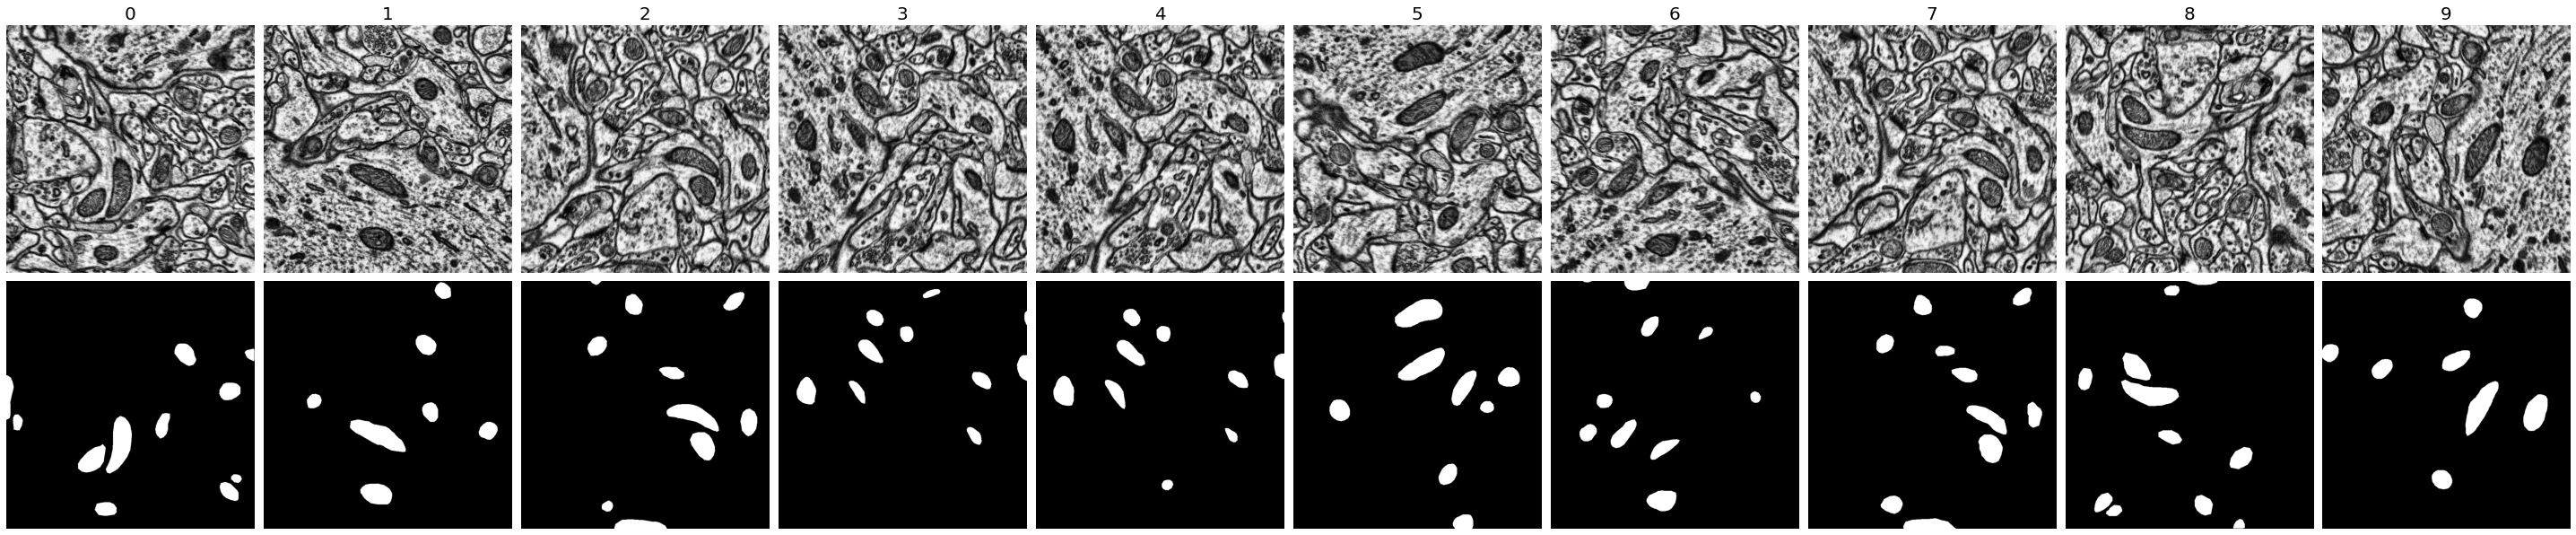

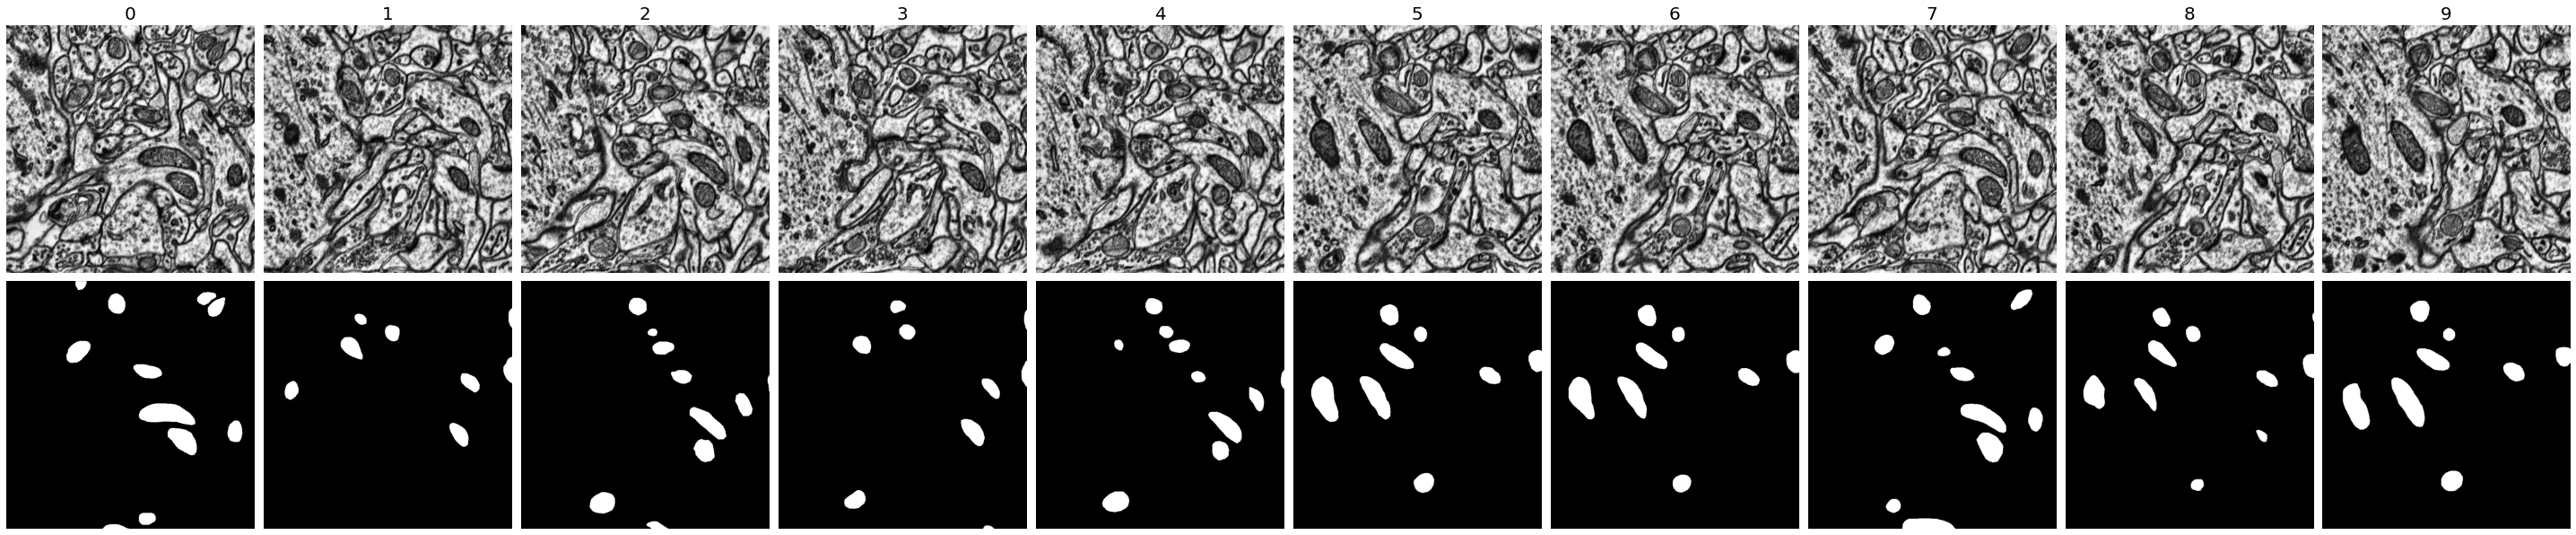

In [5]:
# Loop over the training set then the validation set
for x,y in zip([X_train[:10], X_test[:10]],[Y_train[:10], Y_test[:10]]):
    # Define the figure size canvas
    fig, axs = plt.subplots(ncols=len(x), nrows=2, figsize=(4*len(x), 8.5), tight_layout=True)

    for i, (x, y) in enumerate(zip(x, y)):
        # Show the images
        axs[0, i].imshow(x, cmap='gray')
        axs[0, i].set_title(f'{i}', fontsize=20)

        # Show the masks
        axs[1, i].imshow(y, cmap='gray')

        # Remove the axis
        for ax in axs[:,i]:
            ax.set_axis_off()

    plt.show()

In [6]:
# Define the config by setting some parameter values
conf = Config2D(n_rays=32, grid=(32,32), use_gpu=False, n_channel_in=1)

# Save model to the specified directory
model = StarDist2D(conf, name='stardist_tutorial', basedir='Models/')

# Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

base_model.py (149): output path for model already exists, files may be overwritten: /home/ahmed/Repositories/GUV-StarDist/Models/stardist_tutorial
2022-09-27 19:19:36.560671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 19:19:36.560843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 19:19:36.561180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-27 19:19:36.561483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cann

Using default values: prob_thresh=0.5, nms_thresh=0.4.


2022-09-27 19:19:37.344288: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2147483648 exceeds 10% of free system memory.
2022-09-27 19:19:37.596486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2147483648 exceeds 10% of free system memory.


1/1 [==============================] - 2s 2s/step


2022-09-27 19:19:39.602089: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2147483648 exceeds 10% of free system memory.
2022-09-27 19:19:39.828787: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2147483648 exceeds 10% of free system memory.


1/1 [==============================] - 2s 2s/step
median object size:      [707. 568.]
network field of view :  [1225 1290]


In [7]:
history = model.train(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1000, steps_per_epoch=256)

Epoch 1/1000
Cause: Unable to locate the source code of <function _gcd_import at 0x7f309bc3f400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x7f309bc3f400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the fun

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30,10), tight_layout=True)
axs[0,0].plot(history.history['loss'], label='Training', alpha=0.7)
axs[0,0].plot(history.history['val_loss'], label='Validation', alpha=0.7)
axs[0,0].set_title('Loss', fontsize=12)
axs[0,0].legend(fontsize=12)
axs[0,0].grid(alpha=0.3)

axs[0,1].plot(history.history['prob_loss'], label='Training', alpha=0.7)
axs[0,1].plot(history.history['val_prob_loss'], label='Validation', alpha=0.7)
axs[0,1].set_title('Prob_loss', fontsize=12)
axs[0,1].legend(fontsize=12)
axs[0,1].grid(alpha=0.3)

axs[0,2].plot(history.history['dist_loss'], label='Training', alpha=0.7)
axs[0,2].plot(history.history['val_dist_loss'], label='Validation', alpha=0.7)
axs[0,2].set_title('Dist_loss', fontsize=12)
axs[0,2].legend(fontsize=12)
axs[0,2].grid(alpha=0.3)

axs[0,3].plot(history.history['prob_kld'], label='Training', alpha=0.7)
axs[0,3].plot(history.history['val_prob_kld'], label='Validation', alpha=0.7)
axs[0,3].set_title('Prob_kld', fontsize=12)
axs[0,3].legend(fontsize=12)
axs[0,3].grid(alpha=0.3)

axs[1,0].plot(history.history['dist_relevant_mae'], label='Training', alpha=0.7)
axs[1,0].plot(history.history['val_dist_relevant_mae'], label='Validation', alpha=0.7)
axs[1,0].set_title('Dist_relevant_mae', fontsize=12)
axs[1,0].set_xlabel('Epoch', fontsize=12)
axs[1,0].legend(fontsize=12)
axs[1,0].grid(alpha=0.3)

axs[1,1].plot(history.history['dist_relevant_mse'], label='Training', alpha=0.7)
axs[1,1].plot(history.history['val_dist_relevant_mse'], label='Validation', alpha=0.7)
axs[1,1].set_title('Dist_relevant_mse', fontsize=12)
axs[1,1].set_xlabel('Epoch', fontsize=12)
axs[1,1].legend(fontsize=12)
axs[1,1].grid(alpha=0.3)

axs[1,2].plot(history.history['dist_dist_iou_metric'], label='Training', alpha=0.7)
axs[1,2].plot(history.history['val_dist_dist_iou_metric'], label='Validation', alpha=0.7)
axs[1,2].set_title('Dist_dist_iou_metric', fontsize=12)
axs[1,2].set_xlabel('Epoch', fontsize=12)
axs[1,2].legend(fontsize=12)
axs[1,2].grid(alpha=0.3)

axs[1,3].plot(history.history['lr'], label='Training', alpha=0.7)
axs[1,3].set_title('lr', fontsize=12)
axs[1,3].set_xlabel('Epoch', fontsize=12)
axs[1,3].legend(fontsize=12)
axs[1,3].grid(alpha=0.3)

In [ ]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_test, Y_test)

In [ ]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_test)]

#PLot original labels and predcitions
plot_img_label(X_test[0],Y_test[0], label_title="Ground Truth")
plot_img_label(X_test[0],Y_val_pred[0], label_title="Prediction")

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.3)]

#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();